In [104]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Proyecto de grado-Extensión/Registro de Nubes/Registro de Nubes')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1bUVmxKZXlCNnu4CbA53Po31b084HWCvL/Registro de Nubes


In [105]:
import os
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt

In [106]:
#segundo modelo entrenado
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/lastTrain')

## DPDist

In [107]:
def get_bn_decay(batch):
  bn_momentum = tf.train.exponential_decay(
                                            0.5,
                                            batch,#*BATCH_SIZE,
                                            float(0.5),
                                            0.5,
                                            staircase=True)

In [108]:
def initialize_uninitialized_vars(sess):
    from itertools import compress
    global_vars = tf.global_variables()
    is_not_initialized = sess.run([~(tf.is_variable_initialized(var)) \
                                   for var in global_vars])
    not_initialized_vars = list(compress(global_vars, is_not_initialized))

    if len(not_initialized_vars):
        print('init not_initialized')
        print(not_initialized_vars)
        sess.run(tf.variables_initializer(not_initialized_vars))

In [109]:
def DPDIST(nubeA, nubeB):
  import tensorflow.compat.v1 as tf
  input_1 = nubeA.reshape(16, 64, SB.shape[1])
  input_2 = nubeB.reshape(16,  64 ,SA.shape[1])
  noise = np.zeros((16, 64, 3))
  from tensorflow.python.framework import meta_graph
  graph = tf.Graph()
  with graph.as_default():
    with tf.device('/gpu:' + str(0)):
        batch = tf.get_variable('batch', [], initializer=tf.constant_initializer(0), trainable=False)
        #bn_decay = get_bn_decay(batch)
        #tf.summary.scalar('bn_decay', bn_decay) 
        is_training_pl_1 = tf.placeholder(tf.bool, shape=())
        is_training_pl_2 = tf.placeholder(tf.bool, shape=())
        x1 = tf.placeholder(tf.float32, (16, 64,3), name='input1')
        x2 = tf.placeholder(tf.float32, (16, 64,3), name='input2')
        x3 = tf.placeholder(tf.float32, (16, 64,3), name='input3')
        saver31 = tf.train.import_meta_graph('./model.ckpt.meta',
                                            import_scope='g1',
                                            input_map={'input1': x1,
                                                      'input2': x2,
                                                      'Placeholder': is_training_pl_1,
                                                      'add_noise':x3}
                                            )
        labels12 = graph.get_tensor_by_name('g1/labels12:0')
        pred_AB3 = (graph.get_tensor_by_name('g1/pc_compare/output1:0'))
        pred_BA3 = (graph.get_tensor_by_name('g1/pc_compare/output2:0'))
        loss_p = (tf.reduce_mean(pred_AB3[:,:,:,0]) + tf.reduce_mean(pred_BA3[:,:,:,0]))/2.0
    # Create a session
    init = tf.global_variables_initializer()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess3 = tf.InteractiveSession(config=config)
    sess3.run(init)
    #DPDist weights loader
    MODEL_PATH = './model.ckpt'
    saver31.restore(sess3, MODEL_PATH)
    initialize_uninitialized_vars(sess3)
    #print('model restored')
    ops3 = {'x1':x1,
            'x2':x2,
            'add_noise':x3,
            # 'pc_Crec':pc_Crec,
            'is_training_pl1':is_training_pl_1,
            'loss':loss_p,
            'labels12':labels12,
            'pred': {'pred_AB':pred_AB3,'pred_BA':pred_BA3}}

    feed_dict={ops3['x1']:input_1,
              ops3['x2']: input_2,
              ops3['is_training_pl1']:False,
              ops3['add_noise']:noise,
              # train_opt_pred3:True,
              }        
    result =sess3.run([ops3['pred']], feed_dict=feed_dict)
    '''
    resultBA=sess3.run(pred_BA3, feed_dict=feed_dict_testing)
    resultAB_0 = resultAB[:,:,:,:]
    resultBA_0 = resultBA[:,:,:,:]  
    resultAB_0 = resultAB_0.reshape(1024,3)
    resultBA_0 = resultAB_0.reshape(1024,3)
    '''
    sess3.close()
    result = np.array(result)
    DistAB = result[0]['pred_AB']
    vDistAB = DistAB.reshape(1024,3)
    DistBA = result[0]['pred_BA']
    vDistBA = DistBA.reshape(1024,3)
  return vDistAB, vDistBA,  #vectores de distanciaAB, #vectores de distanciaBA

In [110]:
def DPDISTnormaAndDistPc_Pc(vectorDistAB, vectorDistBA):
  DPDistanceABmap = []
  for i in range(len(vectorDistAB)):
    DPDistanceAB = np.linalg.norm(vectorDistAB[i,:])
    DPDistanceABmap.append(DPDistanceAB)
  DPDistanceABmap = np.array(DPDistanceABmap)

  DPDistanceBAmap = []
  for i in range(len(vectorDistBA)):
    DPDistanceBA= np.linalg.norm(vectorDistBA[i,:])
    DPDistanceBAmap.append(DPDistanceBA)
  DPDistanceBAmap = np.array(DPDistanceBAmap)

  dist_pcA_pcB=((1/SA.shape[0])*np.sum(DPDistanceABmap))+((1/SB.shape[0])*np.sum(DPDistanceBAmap))

  return DPDistanceABmap, DPDistanceBAmap, round(dist_pcA_pcB, 4) #normaVectoresAB, #normaVectoresBA, #distancia de nube a nube 

## Funciones de rotación

In [111]:
import math
from functools import reduce
import numpy as np
def rotacionZYX(radz, rady, radx):
  Ms = []
  z= radz
  y= rady
  x= radx

  cosz = math.cos(z)
  sinz = math.sin(z)
  Ms.append(np.array(
          [[cosz, -sinz, 0],
            [sinz, cosz, 0],
            [0, 0, 1]]))

  cosy = math.cos(y)
  siny = math.sin(y)
  Ms.append(np.array(
          [[cosy, 0, siny],
            [0, 1, 0],
            [-siny, 0, cosy]]))

  cosx = math.cos(x)
  sinx = math.sin(x)
  Ms.append(np.array(
          [[1, 0, 0],
            [0, cosx, -sinx],
            [0, sinx, cosx]]))


  Mzxy = reduce(np.dot, Ms[::-1])
  return Mzxy

In [112]:
def rotation_matrix(theta):
    return np.array([[1,0, 0],
                     [0,np.cos(theta), -np.sin(theta)],
                     [0,np.sin(theta), np.cos(theta)]])

In [113]:
def Y_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),  0,  np.sin(theta)],
                     [0,              1,              0],
                     [-np.sin(theta), 0,  np.cos(theta)]])

In [114]:
def Z_axis_rotation_matrix(theta):
    return np.array([[np.cos(theta),   -np.sin(theta),    0],
                     [np.sin(theta),    np.cos(theta),    0],
                     [0,                0,                1]])

## Read Data


In [115]:
def read_pc_by_class(num_point_Clouds, num_points, clase, inicial_path):
  import random
  r = random.randint(0, 20)
  lista = []
  path_i = inicial_path + '/' + clase + '/' + clase +'_'
  
  for i in range(1, num_point_Clouds+1):
    if(i<10):
      path = path_i + '00' + str(0)+str(i) + '.txt'
    if(i>=10 and i<100):
      path = path_i + '00' + str(i) + '.txt'
    if(i>=100 and i<1000):
      path = path_i + '0' + str(i) + '.txt'
    if(i>=1000):
      path = path_i + str(i) + '.txt'
    pC = np.loadtxt(path, delimiter=',', usecols=(0,1,2))
    pC = pC[r*100:r*100+num_points, :]
    lista.append(pC)



  return lista


In [116]:
os.chdir('/content/drive/MyDrive/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64')
!pwd

/content/drive/.shortcut-targets-by-id/1asBEAN-S2b77S-W1swprmpEcUXwsqzS3/PROYECTO DE GRADO/Code/DPDist-master/log/test1__imp_type_1enc_3dmfvEmbS512BN0LR0001wd0sigma125K5AUG1lsl1_distnoise0chairov1np64


In [117]:
chair = read_pc_by_class(20, 5000, 'chair', '../../data/modelnet40_normal_resampled')

#### DPDIST AB SUPERFICIE B

In [118]:
nube = chair[0]
SA = nube[:1024,:]
SB = nube [2048:3072,:]

In [119]:
import random

r = random.randint(1,10)
rt = random.random()
Rm = rotation_matrix(-np.pi/8)
SB= np.dot(Rm,SB.T).T + 0.1

In [120]:
vDistAB, vDistBA=DPDIST(SA,SB)

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [121]:
normAB, normBA, DPDistPC_PC = DPDISTnormaAndDistPc_Pc(vDistAB, vDistBA)

In [149]:
normAB

array([0.        , 0.03198061, 0.24619892, ..., 0.        , 0.09746008,
       0.02471889], dtype=float32)

In [150]:
normBA

array([0.10779755, 0.18720081, 0.10743851, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [122]:
normAB[:100]

array([0.        , 0.03198061, 0.24619892, 0.32139364, 0.38466635,
       0.        , 0.10641348, 0.05176502, 0.05343094, 0.33666316,
       0.09884747, 0.26040885, 0.0858626 , 0.16837722, 0.24413152,
       0.08329715, 0.00570724, 0.02860198, 0.07604158, 0.35083425,
       0.13030677, 0.03936027, 0.0928527 , 0.01490355, 0.00161832,
       0.28409168, 0.08915318, 0.01723282, 0.22603382, 0.17863242,
       0.03982365, 0.        , 0.18062685, 0.27841377, 0.01871222,
       0.09313493, 0.14047419, 0.21311094, 0.07881056, 0.04836161,
       0.        , 0.03550684, 0.1873666 , 0.09654586, 0.09311458,
       0.09081129, 0.05715447, 0.23168904, 0.13431759, 0.32590973,
       0.08525421, 0.        , 0.07605384, 0.20450866, 0.3796874 ,
       0.12431601, 0.19056205, 0.07965077, 0.24792555, 0.25025922,
       0.08803766, 0.23634897, 0.17755532, 0.24974272, 0.22280648,
       0.1048741 , 0.23116928, 0.09113483, 0.09956197, 0.05743916,
       0.07553151, 0.08815157, 0.17789866, 0.10819433, 0.06337

In [123]:
normBA[:100]

array([0.10779755, 0.18720081, 0.10743851, 0.246663  , 0.08944971,
       0.09270427, 0.18349372, 0.08348117, 0.02743563, 0.24630937,
       0.26206127, 0.01412566, 0.04034113, 0.22395794, 0.06695796,
       0.02775862, 0.23445173, 0.20442508, 0.02957256, 0.22268619,
       0.08203666, 0.2453311 , 0.20796898, 0.00222233, 0.03582619,
       0.09354357, 0.28714594, 0.02913449, 0.01022781, 0.21518528,
       0.01560444, 0.        , 0.20136675, 0.03541655, 0.14664936,
       0.1771927 , 0.11295278, 0.0091893 , 0.21519086, 0.07179241,
       0.        , 0.01417074, 0.22806098, 0.00327078, 0.22927646,
       0.22762832, 0.13514844, 0.03480771, 0.07818482, 0.07847501,
       0.11474703, 0.23427865, 0.        , 0.1863046 , 0.10023519,
       0.27142265, 0.17795737, 0.1566699 , 0.17097753, 0.09916683,
       0.10111777, 0.02500251, 0.17281932, 0.00117861, 0.24681526,
       0.        , 0.06884327, 0.12638782, 0.24176237, 0.02393084,
       0.060069  , 0.        , 0.21687616, 0.11029155, 0.15781

In [124]:
N = (normAB+normBA)

In [125]:
Vect = SA - SB

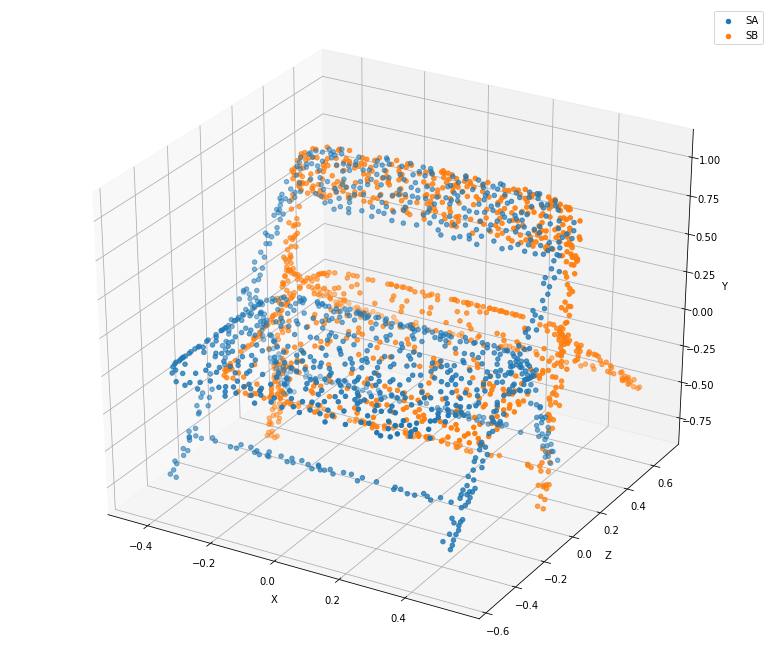

In [126]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['SA','SB'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [152]:
subyacente = []
for i in range(len(vDistBA)):
  Sb = SA[i]+vDistBA[i]
  subyacente.append(Sb)
subyacente = np.array(subyacente)

In [153]:
subyacente2 = []
for i in range(len(vDistBA)):
  Sb = SB[i]+vDistBA[i]
  subyacente2.append(Sb)
subyacente2 = np.array(subyacente2)

In [154]:
M = subyacente2-subyacente

'\nX = M[:,:]\nY = M[:,1]\nZ = M[:,2]\nax.scatter(Z,Y)\n\n'

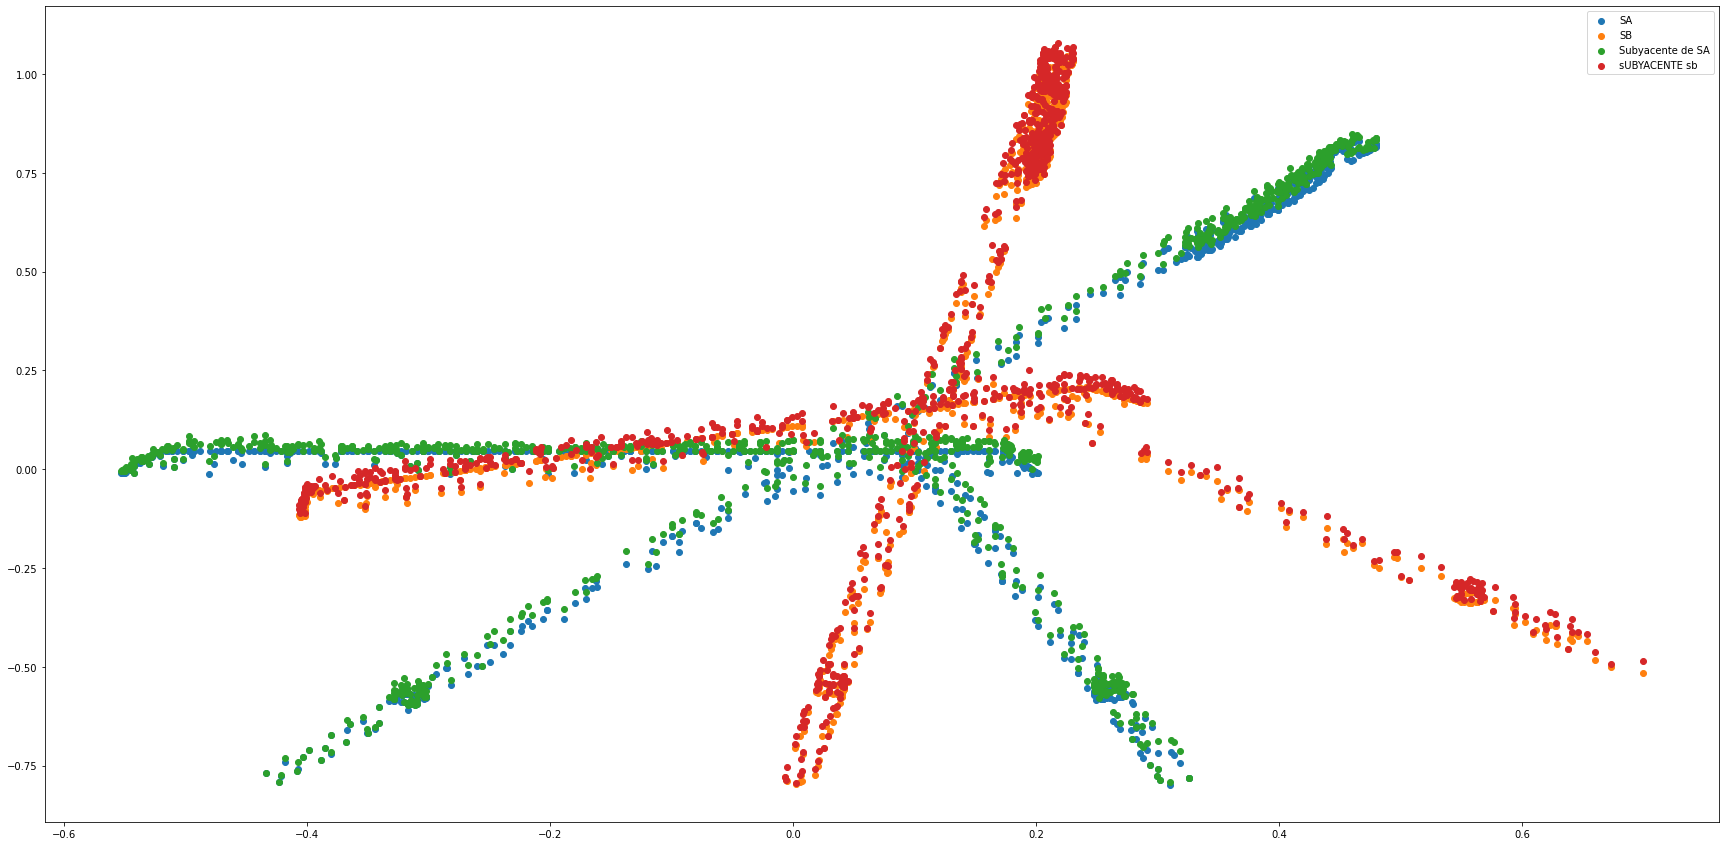

In [155]:
fig = plt.figure(figsize=(30,15))

ax = fig.add_subplot()

X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter(Z,Y)



X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter(Z,Y)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter(Z,Y)

X = subyacente2[:,0]
Y = subyacente2[:,1]
Z = subyacente2[:,2]
ax.scatter(Z,Y)
ax.legend(['SA','SB','Subyacente de SA', 'sUBYACENTE sb'])
'''
X = M[:,:]
Y = M[:,1]
Z = M[:,2]
ax.scatter(Z,Y)

'''

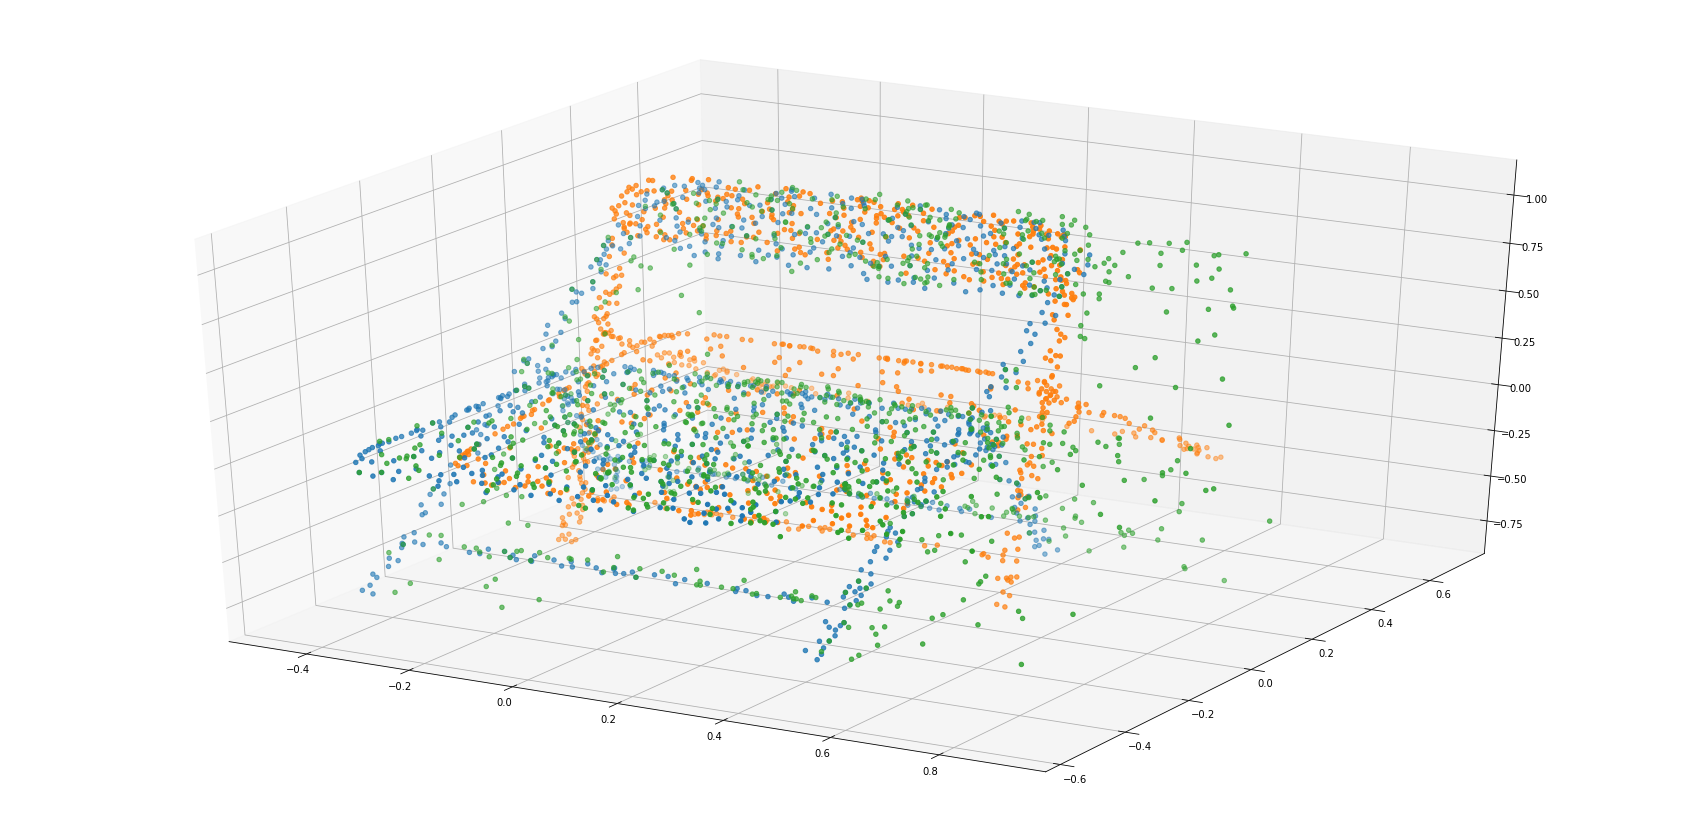

In [146]:
fig = plt.figure(figsize=(30,15))

ax = fig.add_subplot(projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)

X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y)

'''
ax.quiver(SB[:][:], SB[:][2], SB[:][1], DistBA[:][:], DistBA[:][2] ,DistBA[:][1], arrow_length_ratio=0.01, color='r')
'''
plt.show()

In [138]:
from scipy.stats import moment
moment(SA, moment=1)

array([0., 0., 0.])

In [139]:
moment(SB, moment=1)

array([0., 0., 0.])

In [140]:
moment(SA, moment=2)

array([0.0909293 , 0.18030812, 0.09353392])

In [141]:
moment(SB, moment=2)

array([0.09733783, 0.24088547, 0.05522788])

NameError: ignored

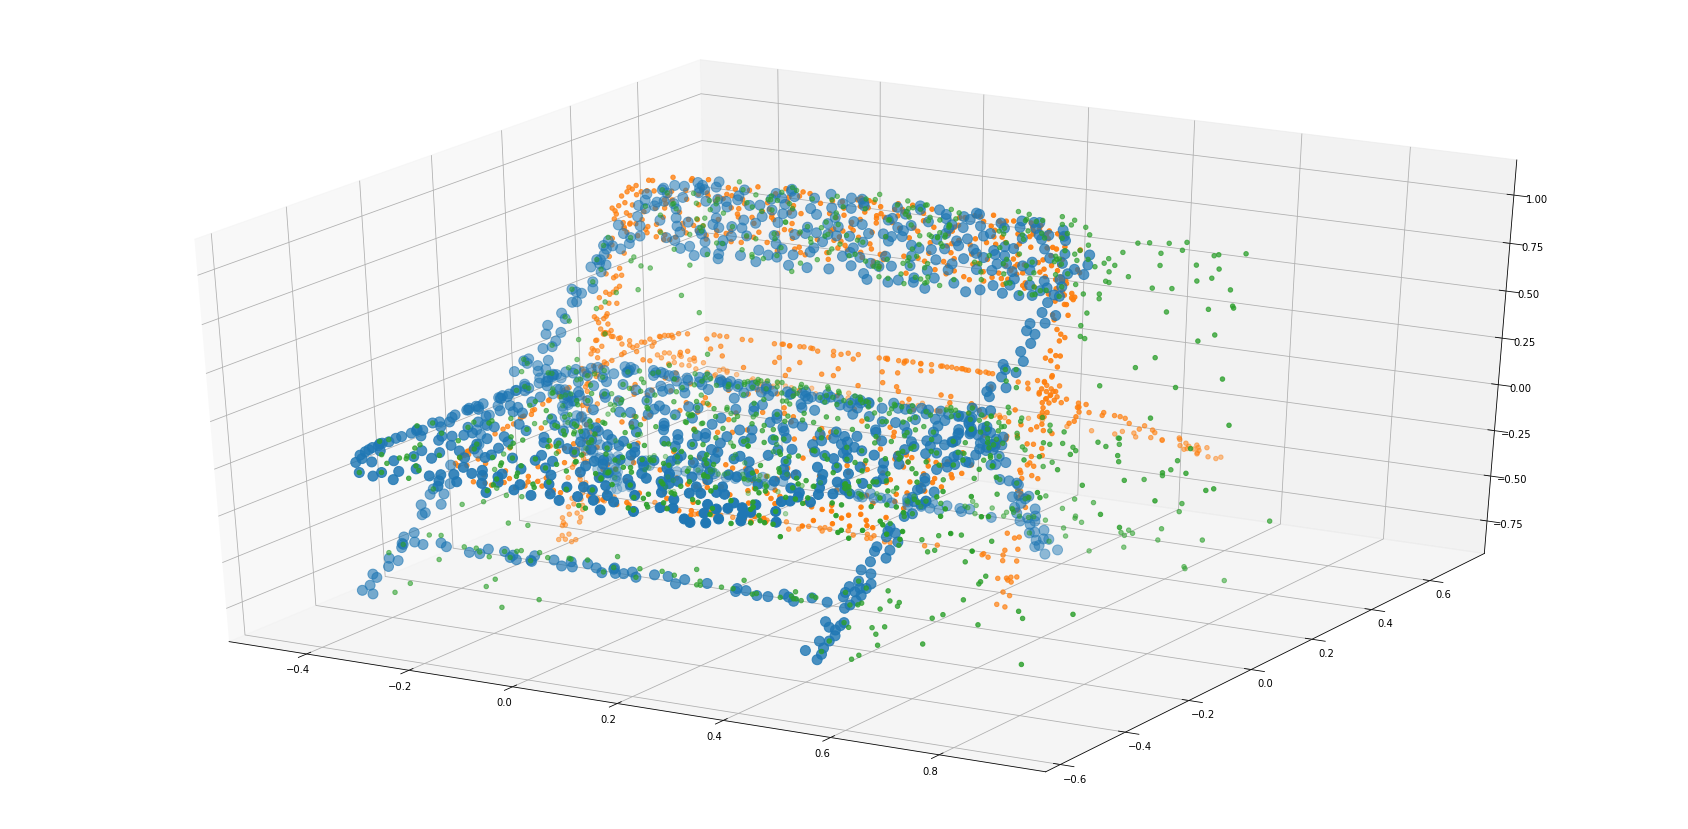

In [132]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')


X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y, s=100)


X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y)


for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], arrow_length_ratio=0.01, color='r')
  ax.set_xlim(-0.6,1.1)
  ax.set_ylim(-0.8,1.1)
  ax.set_zlim(-0.7,1.5)

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','SB','Subyacente de SA', 'DPDistBA'])
plt.show()

In [ ]:
subyacente2 = []
for i in range(len(DistBA)):
  Sb = SA[i]+DistAB[i]
  subyacente2.append(Sb)
subyacente2 = np.array(subyacente2)

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')


X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y, s=100)

X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y, s=100)

'''
for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], color='r')
  ax.set_xlim(-0.6,2.1)
  ax.set_ylim(-0.8,2.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','SB'])
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')





X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y, s=100)

X = subyacente2[:,0]
Y = subyacente2[:,1]
Z = subyacente2[:,2]
ax.scatter3D(X,Z,Y, s=100)

'''
for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], color='r')
  ax.set_xlim(-0.6,2.1)
  ax.set_ylim(-0.8,2.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['Subyacente de SA','Subyacente de SB'])
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y, s=100)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y, s=100)




ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','Subyacente de SA'])
plt.show()

In [ ]:
def nearest_neighbor(src, dst):
    from sklearn.neighbors import NearestNeighbors
    #Encuentra el vecino más cercano mediante el método euclidiano
    #src Matriz de puntos origen
    #dst Matriz de puntos destino
    #Retorna las distancias euclidianas del vecino más cercano y sus indices

    if (src.shape == dst.shape): #Verifica que las nubes de puntos tengan la misma dimensión
      
      neigh = NearestNeighbors(n_neighbors=1) #Busca un vecino 
      neigh.fit(dst) #Ajusta el estimador de vecinos más cercanos del conjunto de datos de entrenamiento
      distances, indices = neigh.kneighbors(src, return_distance=True) #Encuentra los K-vecinos de un punto
    
    else:
      print('Las dimensiones de las nubes de puntos no corresponden o son diferentes' )

    
    return distances.ravel(), indices.ravel()

In [ ]:
distances, indices = nearest_neighbor(SA, subyacente2)

In [ ]:
indices

In [ ]:

import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)

X = subyacente2[:,0]
Y = subyacente2[:,1]
Z = subyacente2[:,2]
ax.scatter3D(X,Z,Y, )


for i in range(1024):
  ax.quiver(SA[i][0], SA[i][2], SA[i][1], subyacente2[indices[i],0]-SA[i][0], subyacente2[indices[i],2]-SA[i][2],  subyacente2[indices[i],1]-SA[i][1], arrow_length_ratio=0.2, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','Subyacente2 de SA'])
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)

X = subyacente2[:,0]
Y = subyacente2[:,1]
Z = subyacente2[:,2]
ax.scatter3D(X,Z,Y, )


for i in range(1024):
  ax.quiver(SA[i][0], SA[i][2], SA[i][1], subyacente2[indices[i],0]-SA[i][0], subyacente2[indices[i],2]-SA[i][2],  subyacente2[indices[i],1]-SA[i][1], arrow_length_ratio=0.2, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','Subyacente2 de SA'])
plt.show()

In [ ]:
AmatchSa=subyacente2[indices]

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = AmatchSa[:,0]
Y = AmatchSa[:,1]
Z = AmatchSa[:,2]
ax.scatter3D(X,Z,Y)

In [ ]:
superficie = []
for i in range(len(DistBA)):
  Sp= AmatchSa[i]-DistAB[i]
  superficie.append(Sp)
superficie = np.array(superficie)

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')

'''
X = AmatchSa[:,0]
Y = AmatchSa[:,1]
Z = AmatchSa[:,2]
ax.scatter3D(X,Z,Y, s=100)
'''

X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)

X = superficie[:,0]
Y = superficie[:,1]
Z = superficie[:,2]
ax.scatter3D(X,Z,Y)


for i in range(10):
  ax.quiver(superficie[i][0], superficie[i][2], superficie[i][1], SB[i][0]-superficie[i][0], SB[i][2]-superficie[i][2],  SB[i][1]-superficie[i][1], arrow_length_ratio=0.2, color='r')

'''
for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], arrow_length_ratio=0.01, color='r')
  ax.set_xlim(-0.6,1.1)
  ax.set_ylim(-0.8,1.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','SB','superficie de SA', 'DPDistBA'])
plt.show()

#### DPDIST AB SUPERFICIE A

In [ ]:
nube = chair[0]
SA = nube[:1024,:]
SB = nube [2048:3072,:]

In [ ]:
import random

r = random.randint(1,10)
rt = random.random()
Rm = rotation_matrix(np.pi/8)
SB= np.dot(Rm,SB.T).T 

In [ ]:
DistAB, DistBA, DPDistAB, lossABBA=DPDist(SB,SA)

In [ ]:
np.mean(DistBA)

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['SA','SB'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
normDistBA = []
for i in range(len(DistBA)):
  DPDistanceBA = np.linalg.norm(DistBA[i,:])
  normDistBA.append(DPDistanceBA)
normDistBA = np.array(normDistBA)

In [ ]:
'''
dirDistAB = []
for i in range(len(DistAB)):
  Dir = DistAB[i]/normDistAB[i]
  dirDistAB.append(Dir)
dirDistAB = np.array(dirDistAB)
'''

In [ ]:
subyacente = []
for i in range(len(DistBA)):
  Sb = SB[i]+DistBA[i]
  subyacente.append(Sb)
subyacente = np.array(subyacente)

In [ ]:
fig = plt.figure(figsize=(30,15))

ax = fig.add_subplot(projection='3d')
X = SB[0,0]
Y = SB[0,1]
Z = SB[0,2]
ax.scatter3D(X,Z,Y)

X = subyacente[0,0]
Y = subyacente[0,1]
Z = subyacente[0,2]
ax.scatter3D(X,Z,Y)


ax.quiver(SB[0][0], SB[0][2], SB[0][1], DistBA[0][0], DistBA[0][2] ,DistBA[0][1], arrow_length_ratio=0.01, color='r')
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')


X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y, s=100)


X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y)


for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], arrow_length_ratio=0.01, color='r')
  ax.set_xlim(-0.6,1.1)
  ax.set_ylim(-0.8,1.1)
  ax.set_zlim(-0.7,1.5)

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','SB','Subyacente de SA', 'DPDistBA'])
plt.show()

In [ ]:
subyacente2 = []
for i in range(len(DistBA)):
  Sb = SA[i]+DistAB[i]
  subyacente2.append(Sb)
subyacente2 = np.array(subyacente2)

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')





X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y, s=100)

X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y, s=100)

'''
for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], color='r')
  ax.set_xlim(-0.6,2.1)
  ax.set_ylim(-0.8,2.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','SB'])
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')





X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y, s=100)

X = subyacente2[:,0]
Y = subyacente2[:,1]
Z = subyacente2[:,2]
ax.scatter3D(X,Z,Y, s=100)

'''
for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], color='r')
  ax.set_xlim(-0.6,2.1)
  ax.set_ylim(-0.8,2.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['Subyacente de SA','Subyacente de SB'])
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y, s=100)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y, s=100)

'''
for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], color='r')
  ax.set_xlim(-0.6,2.1)
  ax.set_ylim(-0.8,2.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','Subyacente de SA'])
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y, s=100)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y, s=100)


for i in range(2):
  ax.quiver(subyacente[i][0], subyacente[i][2], subyacente[i][1], SA[i][0]-subyacente[i][0], SA[i][2] -subyacente[i][2],SA[i][1]-subyacente[i][1], arrow_length_ratio=0.1, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','Subyacente de SA'])
plt.show()

In [ ]:
distances, indices = nearest_neighbor(SA, subyacente)

In [ ]:
indices

In [ ]:

import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y, )


for i in range(1024):
  ax.quiver(SA[i][0], SA[i][2], SA[i][1], subyacente[indices[i],0]-SA[i][0], subyacente[indices[i],2]-SA[i][2],  subyacente[indices[i],1]-SA[i][1], arrow_length_ratio=0.2, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','Subyacente de SA'])
plt.show()

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = SA[:,0]
Y = SA[:,1]
Z = SA[:,2]
ax.scatter3D(X,Z,Y)

X = subyacente[:,0]
Y = subyacente[:,1]
Z = subyacente[:,2]
ax.scatter3D(X,Z,Y, )


for i in range(1024):
  ax.quiver(SA[i][0], SA[i][2], SA[i][1], subyacente[indices[i],0]-SA[i][0], subyacente[indices[i],2]-SA[i][2],  subyacente[indices[i],1]-SA[i][1], arrow_length_ratio=0.2, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','Subyacente de SA'])
plt.show()

In [ ]:
AmatchSa=subyacente[indices]

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')



X = AmatchSa[:,0]
Y = AmatchSa[:,1]
Z = AmatchSa[:,2]
ax.scatter3D(X,Z,Y)

In [ ]:
superficie = []
for i in range(len(DistBA)):
  Sp= AmatchSa[i]-DistBA[i]
  superficie.append(Sp)
superficie = np.array(superficie)

In [ ]:
import numpy as np
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')

'''
X = AmatchSa[:,0]
Y = AmatchSa[:,1]
Z = AmatchSa[:,2]
ax.scatter3D(X,Z,Y, s=100)
'''

X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)

X = superficie[:,0]
Y = superficie[:,1]
Z = superficie[:,2]
ax.scatter3D(X,Z,Y)


for i in range(10):
  ax.quiver(superficie[i][0], superficie[i][2], superficie[i][1], SB[i][0]-superficie[i][0], SB[i][2]-superficie[i][2],  SB[i][1]-superficie[i][1], arrow_length_ratio=0.2, color='r')

'''
for i in range(len(SB)):
  ax.quiver(SB[i][0], SB[i][2], SB[i][1], DistBA[i][0], DistBA[i][2] ,DistBA[i][1], arrow_length_ratio=0.01, color='r')
  ax.set_xlim(-0.6,1.1)
  ax.set_ylim(-0.8,1.1)
  ax.set_zlim(-0.7,1.5)
'''
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.legend(['SA','SB','superficie de SA', 'DPDistBA'])
plt.show()

In [ ]:
9
fig = plt.figure(figsize=(30,15))
ax = fig.add_subplot(projection='3d')
ax.quiver(SA[0][0], SA[0][2], SA[0][1], dirDistAB[0][0]-SA[0][0], dirDistAB[0][2]-SA[0][2] ,dirDistAB[0][1]-SA[0][1], length=normDistAB[0], color='r')
ax.scatter3D(SA[0][0], SA[0][2], SA[0][1])
ax.scatter3D(SB[0][0], SB[0][2], SB[0][1])
ax.scatter3D(dirDistAB[0][0], dirDistAB[0][2] ,dirDistAB[0][1])
plt.show()

In [ ]:
NubePrueba = np.zeros([1023,3])

In [ ]:
NubePrueba.shape

In [ ]:
elemento = SA[1].reshape(1,3)

In [ ]:
elementoB = SB[1].reshape(1,3)

In [ ]:
NubePruebaA= np.append(NubePrueba, elemento, axis=0)

In [ ]:
NubePruebaB = np.zeros([1024,3])

In [ ]:
NubePrueba.shape

In [ ]:
NubePruebaA.shape

In [ ]:
NubePruebaB.shape

In [ ]:
DistAB, DistBA, DPDistAB, lossABBA=DPDist(NubePruebaA, NubePruebaB)

In [ ]:
DistAB

In [ ]:
DistBA

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = SA[-1,0] 
Y = SA[-1,1] 
Z = SA[-1,2] 
ax.scatter3D(X,Z,Y, c='R')

X = SB[-1,0]
Y = SB[-1,1]
Z = SB[-1,2]
ax.scatter3D(X,Z,Y, c='g')

ax.quiver(SA[-1,0], SA[-1,2] , SA[-1,1], SB[-1][0]-SA[-1,0],SB[-1][2]-SA[-1,2] ,SB[-1][1]-SA[-1,1], color='r')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
 SB[-1,0]

In [ ]:
SB[-1][0]

In [ ]:
DistAB[0,:]

In [ ]:
SA[0,:]

In [ ]:
vect = SA[0,:]-DistAB[0,:]

In [ ]:
vect

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = DistBA[:1023,0]+vect[0]
Y = DistBA[:1023,1]+vect[1]
Z = DistBA[:1023,2]+vect[2]
ax.scatter3D(X,Z,Y, s=100)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = DistBA[-1,0]
Y = DistBA[-1,1]
Z = DistBA[-1,2]
ax.scatter3D(X,Z,Y, c='R')
X = SA[-1,0]
Y = SA[-1,1]
Z = SA[-1,2]
ax.scatter3D(X,Z,Y, c='g')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()

In [ ]:
fig = plt.figure(figsize=(30,12))
ax = fig.add_subplot(1, 2, 1, projection='3d')
X = NubePrueba[:,0]
Y = NubePrueba[:,1]
Z = NubePrueba[:,2]
ax.scatter3D(X,Z,Y, s=100)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
X = SB[:,0]
Y = SB[:,1]
Z = SB[:,2]
ax.scatter3D(X,Z,Y)
ax.legend(['NubePrueba','SB'])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
plt.show()